# Relax Inc. Take Home Challenge

The goal is to look at take-home users and see who might be most likely to be a future adopted user.

In [11]:
#Import the necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
#Lets start with just loading the data and taking a look

user_data = pd.read_csv('./user_data/takehome_users.csv', encoding = 'latin-1')
user_engagement = pd.read_csv('./user_data/takehome_user_engagement.csv')

In [13]:
#Look at the data for users

user_data.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,4/22/2014 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,11/15/2013 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,3/19/2013 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,5/21/2013 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,1/17/2013 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [14]:
#Look at the data for engagement

user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [15]:
# drop name and email because we don't need that information
user_data.drop(['name','email'], inplace = True, axis = 1)
user_data.head(3)

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,4/22/2014 3:53,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,11/15/2013 3:45,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,3/19/2013 23:14,ORG_INVITE,1.363735e+09,0,0,94,1525.0


In [16]:
#Lets look at the distribution of values for user_data
user_data.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [17]:
#Convert User_engagement to datetime

user_engagement['time_stamp'] = pd.to_datetime(user_engagement['time_stamp'])
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


I think a good approach would be to seperate out the data into two groups. Ones that are our adopted user and one group that isn't. We'll use the "takehome_user_engagement" table to look at that.

In [18]:
#Convert date time to numeric so we can compare the time differences

user_engagement['time_stamp'] = user_engagement['time_stamp'].dt.floor('d').astype(np.int64)
user_engagement = user_engagement.sort_values(['user_id', 'time_stamp']).drop_duplicates()

C:\Users\lutimoth\AppData\Local\Temp/ipykernel_23860/584693850.py:3: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  user_engagement['time_stamp'] = user_engagement['time_stamp'].dt.floor('d').astype(np.int64)


In [19]:
#Sort by each user's id and then the time of their visits
#look at 3 visits at a time and group them together
#Then take the difference between each of these differnce and find the number of days inbetween eahc loging

user_grouped = user_engagement.groupby('user_id')['time_stamp'].rolling(window=3)
time_diff = pd.to_timedelta((user_grouped.max()- user_grouped.min())).dt.days

In [20]:
# Look for users whose difference for 3 logins is less than 7 days to count as adopted 
user_counts = time_diff[time_diff <= 7].index.get_level_values('user_id').tolist()

In [21]:
#Convert to a set list for uniqueness
user_list = list(set(user_counts))

In [22]:
#Binarize and create the adapted feature so we can use this for modeling
user_data['adopted'] = 0
user_data.loc[user_data['object_id'].isin(user_list), 'adopted'] = 1
user_data.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,4/22/2014 3:53,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,11/15/2013 3:45,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,3/19/2013 23:14,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,5/21/2013 8:09,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,1/17/2013 10:14,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


Now that we have 2 groups we can filter our dataframe based on these 2 groups and assess their differences.

Lets try to visually asses what's going on with the data.

<AxesSubplot:>

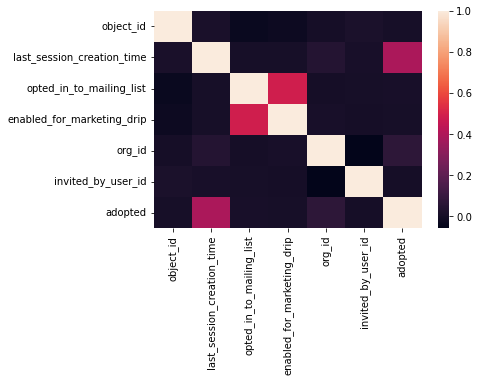

In [23]:
import seaborn as sns

#Start by looking at numerical data
sns.heatmap(user_data.corr())

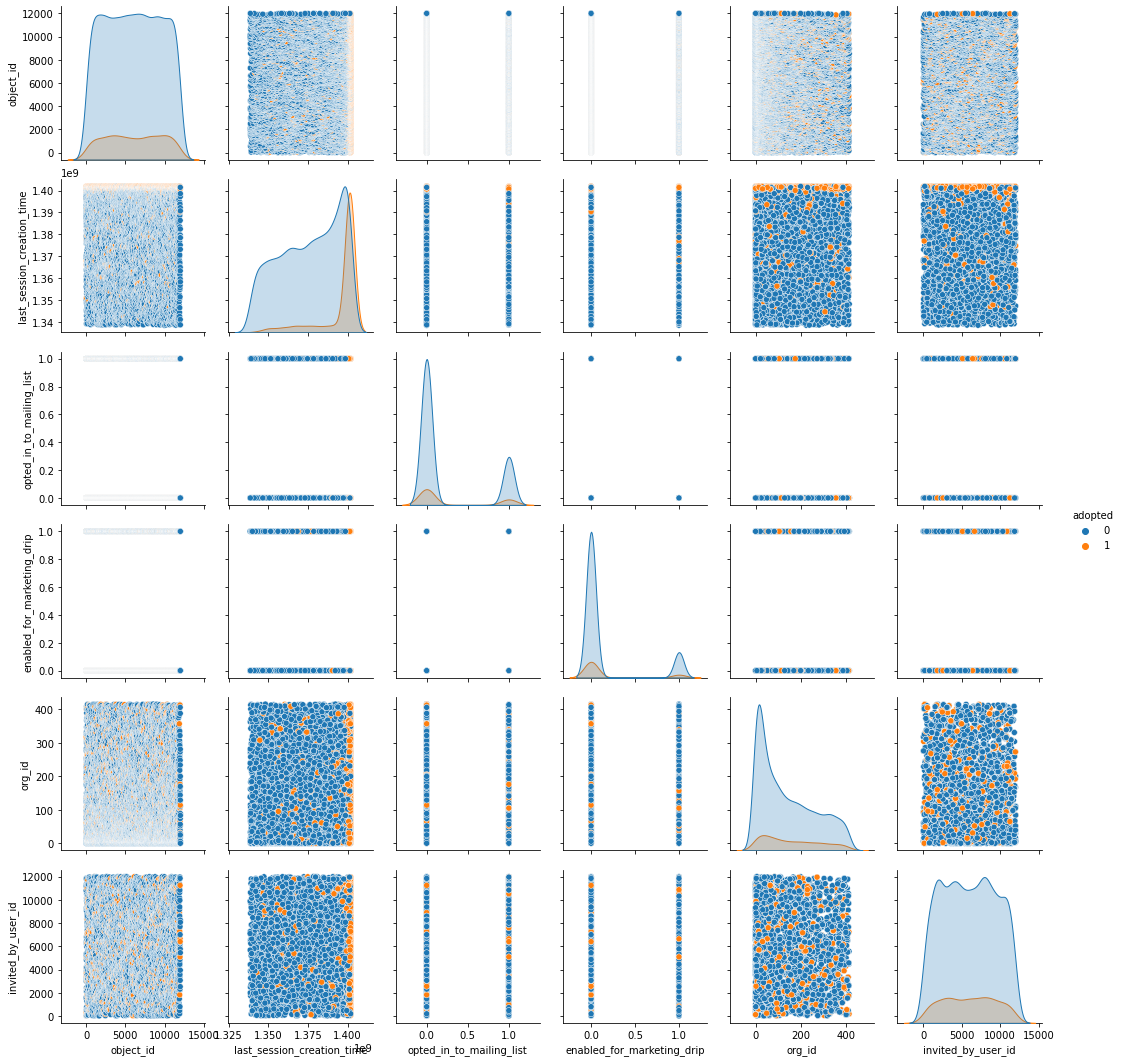

In [24]:
sns.pairplot(user_data, hue = 'adopted')

In [25]:
#fig, ax = plt.subplots(nrows = 1, ncols = 2, tight_layout = True)
#ax[0].hist(adopted['opted_in_to_mailing_list']);
#ax[1].hist(not_adopted['opted_in_to_mailing_list']);
#ax[0].set_xlabel('Adopted in Mailing List');
#ax[1].set_xlabel('Not Adopted in Mailing List');

In [26]:
#fig, ax = plt.subplots(nrows = 1, ncols = 2, tight_layout = True)
#ax[0].hist(adopted['enabled_for_marketing_drip']);
#ax[1].hist(not_adopted['enabled_for_marketing_drip']);
#ax[0].set_xlabel('Adopted in Marketing Drip');
#ax[1].set_xlabel('Not Adopted in Marketing Drip');

In [27]:
#fig, ax = plt.subplots(nrows = 1, ncols = 2, tight_layout = True)
#ax[0].hist(adopted['org_id']);
#ax[1].hist(not_adopted['org_id']);
#ax[0].set_xlabel('Adopted Org');
#ax[1].set_xlabel('Not Adopted Org');

In [28]:
#fig, ax = plt.subplots(nrows = 1, ncols = 2, tight_layout = True)
#ax[0].hist(adopted['invited_by_user_id']);
#ax[1].hist(not_adopted['invited_by_user_id']);
#ax[0].set_xlabel('Adopted Invited By');
#ax[1].set_xlabel('Not Adopted Invited By');

In [29]:
#fig, ax = plt.subplots(nrows = 1, ncols = 2, tight_layout = True, figsize = (15,10))
#ax[0].hist(adopted['creation_source'].sort_values(), density = True);
#ax[1].hist(not_adopted['creation_source'].sort_values(), density = True);
#ax[0].set_xlabel('Adopted Creation Source');
#ax[1].set_xlabel('Not Adopted Creation Source');
#fig.autofmt_xdate(rotation=45);

# XGBoost Decision Tree

Since we have a binary classification problem, we will try XGBoost on this problem!

In [30]:
# Let double check what our data looks like so we know what we want to do
user_data.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,4/22/2014 3:53,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,11/15/2013 3:45,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,3/19/2013 23:14,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,5/21/2013 8:09,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,1/17/2013 10:14,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


Lets clean up our data a little bit
I think we can drop "last session creation time" since adopted users will have a more recent time and non-adopted will not
We can also drop "creation_time" as that is unlikely to give us any insight
We will process object_id as it is numerical and could cause confusion for the model, we will set it as index

In [31]:
#dropping unnecesary columns
user_data.drop(['last_session_creation_time', "creation_time"], inplace = True, axis = 1)

In [32]:
#setting object_id as index
user_data.index = user_data['object_id']
user_data.head()

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
object_id,,,,,,,
1,1,GUEST_INVITE,1,0,11,10803.0,0
2,2,ORG_INVITE,0,0,1,316.0,1
3,3,ORG_INVITE,0,0,94,1525.0,0
4,4,GUEST_INVITE,0,0,1,5151.0,0
5,5,GUEST_INVITE,0,0,193,5240.0,0


In [33]:
#Lets try ordinal encoding our "creation_source"
#I want to try a model without encoding/binarizing our org_id and invited_by_user_id as they have quite a range
#If the model performs poorly, I think we can compare a binarize version as well after
import xgboost as xgb

#Select our variables
X = user_data.drop(['adopted'], axis = 1)
#Convert to dummies and drop first
X = pd.get_dummies(X, columns = ['creation_source'])

y = user_data['adopted']

X.head()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
object_id,,,,,,,,,,
1,1,1,0,11,10803.0,1,0,0,0,0
2,2,0,0,1,316.0,0,1,0,0,0
3,3,0,0,94,1525.0,0,1,0,0,0
4,4,0,0,1,5151.0,1,0,0,0,0
5,5,0,0,193,5240.0,1,0,0,0,0


In [34]:
#Train and test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

In [35]:
from sklearn import metrics

#Enable classifier with default
xgbr = xgb.XGBClassifier()

#fit the model
xgbr.fit(X_train, y_train)

#predict with model
y_pred = xgbr.predict(X_test)

#Look at the score
print(metrics.classification_report(y_test, y_pred))

C:\Users\lutimoth\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:55:22] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      3105
           1       0.28      0.02      0.03       495

    accuracy                           0.86      3600
   macro avg       0.57      0.51      0.48      3600
weighted avg       0.78      0.86      0.80      3600



Our scores for identifying retained are pretty bad! Lets see if we can't improve that.

In [36]:
#Try to improve using Bayesian Optimization
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error

#Convert the dataframe to DMatrix for optimization and speed
dtrain = xgb.DMatrix(X_train, y_train)

#Define the function that will be used
#Set the paramters you wish to change as inputs to function
#Then define the metric you would like to use to optimize the model with

def bo_tune_xgb(max_depth, gamma, n_estimators, learning_rate):
        params = {'max_depth': int(max_depth),
                 'gamma': gamma,
                 'learning_rate': learning_rate,
                 'subsample':0.8,
                 'eta':0.1,
                 }
        #We are using the result of a cross-validation RMSE in order to gauge the model performance
        cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5)
        return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [37]:
#Run the Bayesian Optimization by setting the range of values we'd like to test 
xgb_bo = BayesianOptimization(bo_tune_xgb, 
                             {'max_depth': (3,10),
                             'gamma':(0,1),
                             'n_estimators': (100,120),
                             'learning_rate':(0,1)
                             })

In [38]:
#Run for 13 iterations and find the best paramaters

xgb_bo.maximize(n_iter = 5, init_points = 8, acq = 'ei')

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.4328   |  0.01037  |  0.6593   |  9.653    |  103.9    |
|  2        | -0.3486   |  0.9495   |  0.3958   |  4.696    |  107.0    |
|  3        | -0.3843   |  0.8456   |  0.7795   |  7.083    |  109.9    |
|  4        | -0.4078   |  0.7572   |  0.927    |  8.313    |  111.1    |
|  5        | -0.4075   |  0.3488   |  0.9451   |  5.849    |  118.1    |
|  6        | -0.3712   |  0.4863   |  0.7223   |  4.982    |  107.3    |
|  7        | -0.409    |  0.7294   |  0.8329   |  9.688    |  100.6    |
|  8        | -0.364    |  0.878    |  0.8203   |  4.398    |  107.9    |
|  9        | -0.3884   |  1.0      |  0.009869 |  4.156    |  106.8    |
|  10       | -0.3669   |  0.962    |  0.8857   |  4.512    |  107.8    |
|  11       | -0.347    |  1.0      |  0.3196   |  4.92     |  107.2    |
|  12       | -0.3513   |  1.0      | 

In [39]:
#Extracting the best parameters
params = xgb_bo.max['params']
print(params)

#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])

#Initialize an XGBClassifier with the tuned parameters and fit the training data
xgbr2 = xgb.XGBClassifier(**params)
xgbr2.fit(X_train, y_train)

#predicting for training set
y_pred = xgbr2.predict(X_test)

#Looking at the classification report
print(metrics.classification_report(y_test,y_pred))

{'gamma': 1.0, 'learning_rate': 0.3196193741822835, 'max_depth': 4.9201322002063455, 'n_estimators': 107.17813827986839}
[09:55:34] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lutimoth\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.86      1.00      0.93      3105
           1       0.50      0.00      0.01       495

    accuracy                           0.86      3600
   macro avg       0.68      0.50      0.47      3600
weighted avg       0.81      0.86      0.80      3600



This model is kind of rough. Lets try binarizing our `org_id` and `invited_by_user_id` columns so we can see if being in an org versus not being in an org and being invited vs not being invited matters. We are getting REALLY good F1 scores and extremely high recall on our group 0 (not adopted) but only 50% precision and 0 recall on our group 1 (adopted). That means something might be wrong with the model.



In [40]:
# Lets binarize our invited_by_user_id and our org_id columns to see if belonging to an org or not matters

user_data['invited_by_user_id'] = user_data['invited_by_user_id'].replace(np.NaN, 0)
user_data['invited_binarize'] = 0
user_data.loc[user_data['invited_by_user_id'] > 0, 'invited_binarize'] = 1

user_data['org_binarize'] = 0
user_data.loc[user_data['org_id'] > 0, 'org_binarize'] = 1

#drop the columns
user_data.drop(['org_id','invited_by_user_id'], axis = 1, inplace = True)

user_data.head()

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted,invited_binarize,org_binarize
object_id,,,,,,,
1,1,GUEST_INVITE,1,0,0,1,1
2,2,ORG_INVITE,0,0,1,1,1
3,3,ORG_INVITE,0,0,0,1,1
4,4,GUEST_INVITE,0,0,0,1,1
5,5,GUEST_INVITE,0,0,0,1,1


In [41]:
#Re-Select our variables
X = user_data.drop(['adopted'], axis = 1)
#Convert to dummies
X = pd.get_dummies(X, columns = ['creation_source'])
y = user_data['adopted']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

In [42]:
#Initialize an XGBClassifier with the tuned parameters and fit the training data
xgbr2 = xgb.XGBClassifier(**params)
xgbr2.fit(X_train, y_train)

#predicting for training set
y_pred = xgbr2.predict(X_test)

#Looking at the classification report
print(metrics.classification_report(y_test,y_pred))

[09:55:34] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lutimoth\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.86      1.00      0.93      3099
           1       0.50      0.00      0.00       501

    accuracy                           0.86      3600
   macro avg       0.68      0.50      0.46      3600
weighted avg       0.81      0.86      0.80      3600



In [43]:
#Run for 13 iterations and find the best paramaters

xgb_bo.maximize(n_iter = 5, init_points = 8, acq = 'ei')

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  14       | -0.3991   |  0.7473   |  0.8136   |  8.164    |  116.3    |
|  15       | -0.3505   |  0.03104  |  0.09795  |  6.021    |  100.6    |
|  16       | -0.37     |  0.5868   |  0.7575   |  4.054    |  105.8    |
|  17       | -0.4121   |  0.6794   |  0.8628   |  9.442    |  106.1    |
|  18       | -0.4048   |  0.3094   |  0.8346   |  5.665    |  108.7    |
|  19       | -0.3513   |  0.9181   |  0.6118   |  3.054    |  115.8    |
|  20       | -0.4088   |  0.3213   |  0.7222   |  7.021    |  119.0    |
|  21       | -0.4477   |  0.2716   |  0.9306   |  9.926    |  108.0    |
|  22       | -0.3523   |  1.0      |  0.5479   |  4.937    |  107.1    |
|  23       | -0.3468   |  0.8385   |  0.2501   |  4.949    |  107.0    |
|  24       | -0.5      |  0.0      |  0.0      |  5.636    |  100.4    |
|  25       | -0.3456   |  0.8309   | 

In [44]:
#Extracting the best parameters
params = xgb_bo.max['params']
print(params)

#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])

#Initialize an XGBClassifier with the tuned parameters and fit the training data
xgbr2 = xgb.XGBClassifier(**params)
xgbr2.fit(X_train, y_train)

#predicting for training set
y_pred = xgbr2.predict(X_test)

#Looking at the classification report
print(metrics.classification_report(y_test,y_pred))

{'gamma': 0.830905598022453, 'learning_rate': 0.10975988816718896, 'max_depth': 5.122956608709497, 'n_estimators': 106.69243713486861}
[09:55:45] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lutimoth\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.86      1.00      0.93      3099
           1       0.33      0.00      0.00       501

    accuracy                           0.86      3600
   macro avg       0.60      0.50      0.46      3600
weighted avg       0.79      0.86      0.80      3600



Seems like binarizing made our model even worse! It seems having the wide distribution of data was useful for our tree so we should stick to it.

## Thoughts on Model

It seems that using a decision tree on our data was able to glean some insights and results but ultimately struggled to properly classify our adopted group. 

We had good precision but it seems to almost overfit on the recall of unadopted group while failing to have a precision higher than 50% with practically 0% recall on the adopted group.

It is possible that due to the imbalance of the dataset (majority is unadopted) that it would be useful for us to oversample the adopted group in order to make it more balanced and give our data a better chance at fitting. In future models, I would recommend performing some sort of sampling technique to increase the volume of adopted data. 

For stakeholders, I would recommend looking at gathering more user data and perhaps gathering other features.



## K-Prototypes

We will do a rudimentary K-prototypes to look at clusters. We're primarily interested in 2 groups, will adopt and will not adopt so lets keep it to 2 clusters and see what happens.

In [ ]:
#user_data_notime = user_data.drop(['creation_time', 'last_session_creation_time'], axis = 1)
#user_data_notime

In [ ]:
# Lets binarize our invited_by_user_id and our org_id columns to see if belonging to an org or not matters

#user_data_notime['invited_by_user_id'] = user_data_notime['invited_by_user_id'].replace(np.NaN, 0)
#user_data_notime['invited_binarize'] = 0
#user_data_notime.loc[user_data_notime['invited_by_user_id'] > 0, 'invited_binarize'] = 1

#user_data_notime['org_binarize'] = 0
#user_data_notime.loc[user_data_notime['org_id'] > 0, 'org_binarize'] = 1

#user_data_notime.head()

In [ ]:
# We can now drop org_id and invitation id

#user_data_binarize = user_data_notime.drop(['org_id', 'invited_by_user_id'], axis = 1)
#user_data_binarize.head()

In [ ]:
# To minimize distance and group based on categories and not user id we will also drop object_id

#user_demographic = user_data_binarize.drop(['object_id'], axis = 1)

In [ ]:
#X_train = user_demographic[:8400] #70% split
#X_test = user_demographic[8400:] #30% split


In [ ]:
#from kmodes.kmodes import KModes


#model = KModes(n_clusters = 2, init = 'Cao', n_init = 5)
#model.fit(X_train)
#pred = model.predict(X_test)
#model.cost_

In [ ]:
#model.cluster_centroids_

In [ ]:
#model.labels_

In [ ]:
# We put the cluster labels back into the dataframe to see what we can get

#clusters = np.concatenate([model.labels_, pred])
#clusters

In [ ]:
#user_data_binarize['clusters'] = clusters
#user_data_binarize.head()

In [ ]:
#user_data_binarize['clusters'].value_counts()

It seems like the K-Prototypes struggles to perform clustering of the 2 groups and for the algorithm there isn't a clear breakdown.